# Prognoza temperatury SARIMA

SARIMAX to model jednowymiarowego szeregu czasowego z:

- autoregresją (przeszłe wartości targetu),
- sezonowością,
- opcjonalnymi zmiennymi egzogenicznymi (X).

W SARIMAX target powinien być szeregiem czasowym o stałym kroku, np.:
- temperatura godzinowa,
- ewentualnie temperatura co 3h / 6h.
- target = temperatura godzinowa.

A potem:
- prognozujesz 24 kolejne godziny,
- post-processing: liczysz średnią dnia / nocy z prognozy.

To daje uczciwe porównanie:
- SARIMAX → forecast hourly → agregacja,
- XGBoost → direct forecast agregatów.

Preprocessing
- SARIMAX nie skaluje cech — warto je ustandaryzować,
- brakujące wartości w exog = problem → trzeba uzupełnić.

In [15]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pathlib import Path
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler


plt.style.use('seaborn-v0_8-whitegrid')

DATA_DIR = Path('data')

df = pd.read_csv(DATA_DIR / 'combined.csv', parse_dates=['time'], index_col='time')

In [16]:
# RESAMPLE_I,RESAMPLE_S = 3,"3h"
RESAMPLE_I,RESAMPLE_S = 4,"4h"
# RESAMPLE_I,RESAMPLE_S = 6,"6h"
# expanding mean from temt from the past for this day of year
df = df.sort_index()
df["doy"] = df.index.dayofyear
df["climatology"] = (
    df
    .groupby("doy")["temp"]
    .transform(lambda s: s.expanding().mean().shift(1))
)

df = df.dropna(subset=["climatology"])

df = df.loc["2023-01-01":]
df = df.resample(RESAMPLE_S).mean()

df['pres_lag1'] = df['pres'].shift(1)
df['rhum_lag1'] = df['rhum'].shift(1)
df['cldc_lag1'] = df['cldc'].shift(1)
df['wspd_lag1'] = df['wspd'].shift(1)
df['prcp_lag1'] = df['prcp'].shift(1)

df['pres_trend'] = df['pres'].shift(1) - df['pres'].shift(2)
df['temp_trend'] = df['temp'].shift(1) - df['temp'].shift(2)
df['prcp_trend'] = df['prcp'].shift(1) - df['prcp'].shift(2)
df['dew_point_approx_lag1'] = (
    df['temp'].shift(1) - ((100 - df['rhum'].shift(1)) / 5)
)
df['day_year_sin'] = np.sin(2 * np.pi * df.index.dayofyear / 365)
df['day_year_cos'] = np.cos(2 * np.pi * df.index.dayofyear / 365)

df = df.dropna()

test_hours = 8 * 365
train, test = df.iloc[:-test_hours], df.iloc[-test_hours:]

print(f"Train set: {train.index.min().date()} to {train.index.max().date()}")
print(f"Test set: {test.index.min().date()} to {test.index.max().date()}")

Train set: 2023-01-01 to 2024-08-31
Test set: 2024-08-31 to 2025-12-31


In [17]:
exog_cols = [
    "day_year_sin",
    "day_year_cos",
    "climatology",
    "pres_lag1",
    "rhum_lag1",
    "cldc_lag1",
    "wspd_lag1",
    "prcp_lag1",
    "pres_trend",
    "dew_point_approx_lag1",
]
target_col = "temp"

y_train = train[target_col]
y_test = test[target_col]

exog_train = train[exog_cols]
exog_test = test[exog_cols]

scaler = StandardScaler()
exog_train = scaler.fit_transform(exog_train)
exog_test = scaler.transform(exog_test)


In [18]:
s= 24 / RESAMPLE_I
model = SARIMAX(
    y_train,
    exog=exog_train,
    # v1
    # order=(2, 0, 1),
    # seasonal_order=(1, 0, 1, s),  # s=24/3=8
    # v2
    # order=(2, 0, 2),
    # seasonal_order=(1, 0, 1, s),
    # v3
    order=(3, 0, 1),
    seasonal_order=(1, 0, 1, s),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

result = model.fit(disp=False, maxiter=50)

forecast = result.get_forecast(steps=len(y_test), exog=exog_test)

y_pred = forecast.predicted_mean
y_pred.name = "temp_pred"

print(result.summary())

/home/werka/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                              temp   No. Observations:                 3649
Model:             SARIMAX(3, 0, 1)x(1, 0, 1, 6)   Log Likelihood               -6659.070
Date:                           Sun, 08 Feb 2026   AIC                          13352.140
Time:                                   15:05:20   BIC                          13457.535
Sample:                               01-01-2023   HQIC                         13389.679
                                    - 08-31-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0829      0.221     -0.375      0.708      -0.516       0.350
x2            -1.3641      0.291     -4.692

In [19]:
# forecast = result.get_forecast(
#     steps=8,
#     exog=exog_test[:8]
# )

# y_24h = forecast.predicted_mean

# day = y_24h.between_time("06:00", "17:59").mean()
# night = y_24h.between_time("18:00", "05:59").mean()


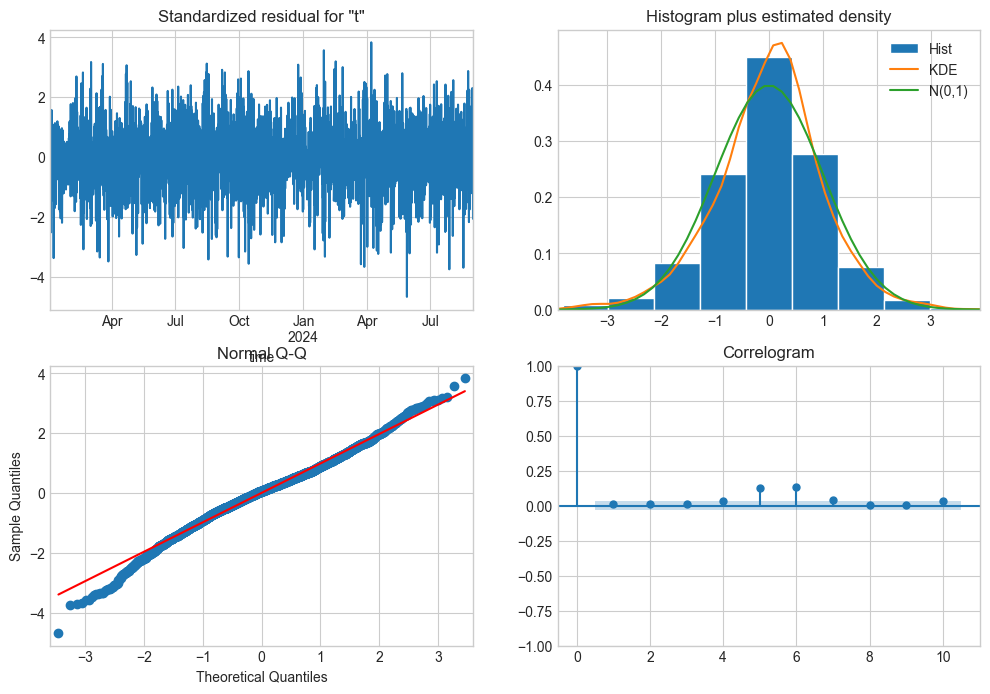

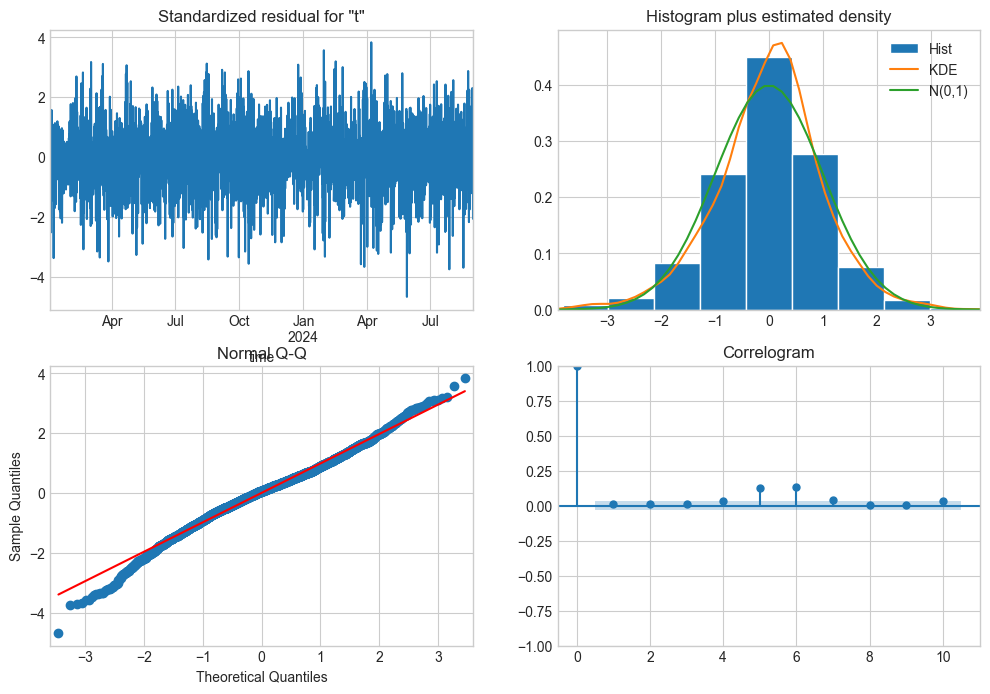

In [20]:
result.plot_diagnostics(figsize=(12, 8))


In [21]:
df_eval = pd.concat([y_test, y_pred], axis=1).dropna()

df_eval["hour"] = df_eval.index.hour
df_eval["date"] = df_eval.index.date

def day_night_agg(df, col):
    day_mask = df.index.hour.isin(range(6,18))

    day = df.loc[day_mask, col].mean()
    night = df.loc[~day_mask, col].mean()

    return pd.Series({
        "day": day,
        "night": night
    })

true_agg = (
    df_eval.groupby(df_eval.index.date)
    .apply(day_night_agg, col="temp")
)
pred_agg = (
    df_eval.groupby(df_eval.index.date)
    .apply(day_night_agg, col="temp_pred")
)

# Żeby nie było NaN
day_df = pd.concat(
    [true_agg["day"], pred_agg["day"]],
    axis=1,
    keys=["true", "pred"]
).dropna()

night_df = pd.concat(
    [true_agg["night"], pred_agg["night"]],
    axis=1,
    keys=["true", "pred"]
).dropna()

In [22]:

def metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

day_rmse, day_mae = metrics(day_df["true"], day_df["pred"])
night_rmse, night_mae = metrics(night_df["true"], night_df["pred"])

print("DAY   RMSE:", day_rmse, "MAE:", day_mae)
print("NIGHT RMSE:", night_rmse, "MAE:", night_mae)


DAY   RMSE: 1.5468950006320332 MAE: 1.2756361192447045
NIGHT RMSE: 1.5736960880501814 MAE: 1.246705465383556


In [23]:
def show_results_sarima(true_agg, pred_agg, subset=60):
    """
    true_agg, pred_agg:
        DataFrame z kolumnami ['day', 'night']
        index = date
    """

    fig, ax = plt.subplots(2, 1, figsize=(12, 10))

    # --- Dzień ---
    ax[0].plot(
        true_agg.index[-subset:],
        true_agg["day"].values[-subset:],
        "o-",
        color="orange",
        label="Rzeczywista (Dzień)",
        alpha=0.6,
    )
    ax[0].plot(
        pred_agg.index[-subset:],
        pred_agg["day"].values[-subset:],
        "x--",
        color="black",
        label="Prognoza SARIMAX",
    )
    ax[0].set_title("Prognoza Dnia - SARIMAX")
    ax[0].legend()

    # --- Noc ---
    ax[1].plot(
        true_agg.index[-subset:],
        true_agg["night"].values[-subset:],
        "o-",
        color="navy",
        label="Rzeczywista (Noc)",
        alpha=0.6,
    )
    ax[1].plot(
        pred_agg.index[-subset:],
        pred_agg["night"].values[-subset:],
        "x--",
        color="red",
        label="Prognoza SARIMAX",
    )
    ax[1].set_title("Prognoza Nocy - SARIMAX")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

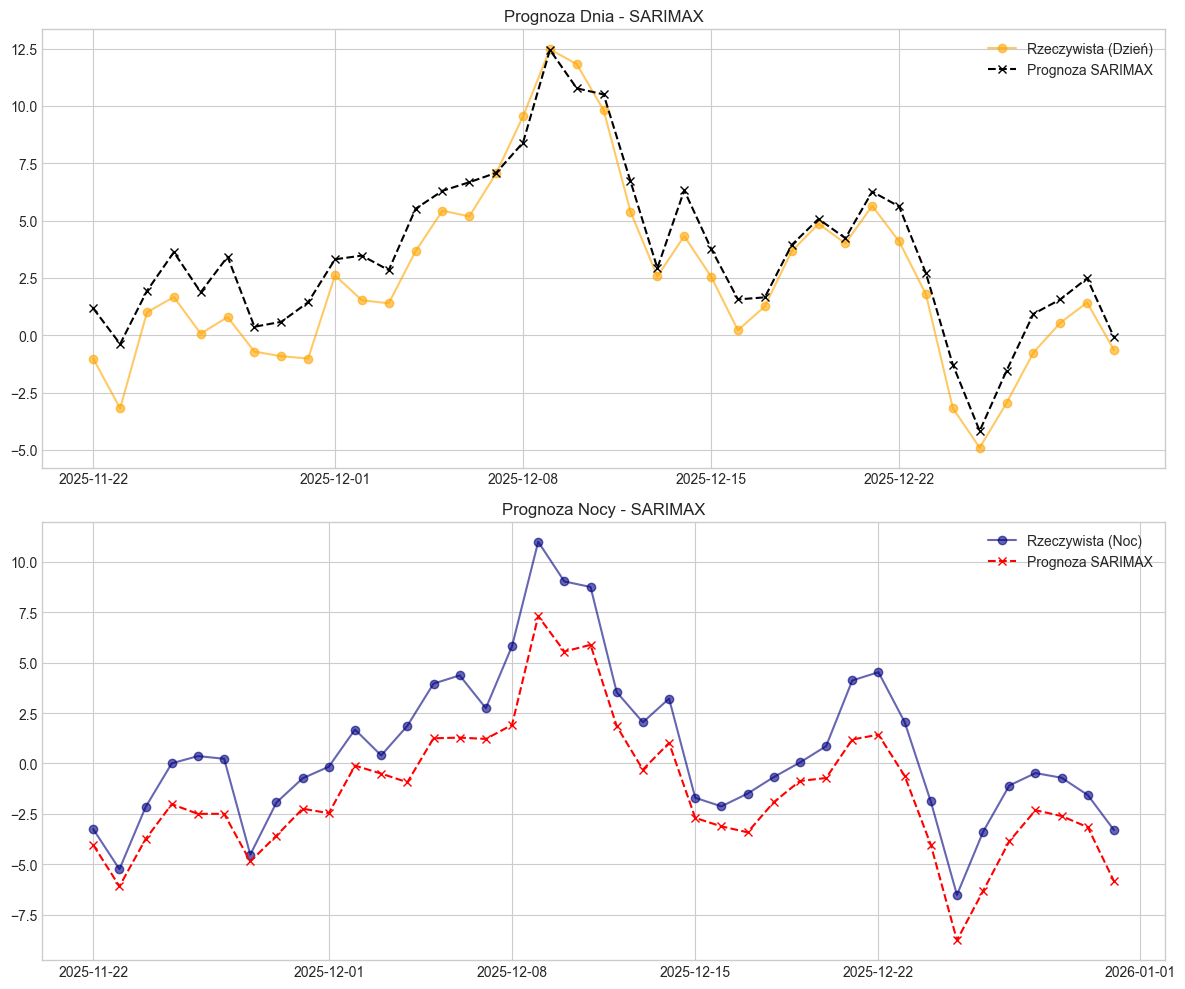

In [25]:
show_results_sarima(true_agg, pred_agg, subset=40)
